# Notebook of building a predictive model from gene expression data for drug sensitivity

## Introduction

The tasks are described in the `input/comp-bio-homework-description.pdf` file.

- Given the data perform a dimensionality reduction with a preferred method and viusalize it.
- Using gene expression data identify biomarkers for Lapatinib sensitivity.
- Build a predictive model for Lapatinib sensitivity and evaluate it's performance.


In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import pdist, squareform

# Setting up pandas printing options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None) 

/projects/ferenc.kagan/ML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setting up working environment
os.environ['OMP_NUM_THREADS'] = '50' 
base_path = Path.cwd()
os.chdir(base_path)

# Print out the current working directory
print(base_path)

/projects/ferenc.kagan/ML


In [3]:
# Read in the provided data

# Gene expression dataset
expr = pd.read_csv("input/CCLE_expression.csv")

# Metadata of the samples
metadata = pd.read_csv("input/sample_info.csv")

#Drug sensitivity data
sens = pd.read_excel("input/GDSC2_fitted_dose_response_25Feb20.xlsx")

## Exploratory data analysis

In [4]:
# Get a sense for the dimensions of the datasets
print(f'Dimensions of expressions are: {expr.shape}')
print(f'Dimensions of metadata are: {metadata.shape}')
print(f'Dimensions of sensitivity are: {sens.shape}')

Dimensions of expressions are: (1393, 19178)
Dimensions of metadata are: (1829, 22)
Dimensions of sensitivity are: (135242, 19)


In [5]:
# Get a sense for the head of the datasets
print(f'Head of expressions are:\n{expr.iloc[:,0:10].head()}\n\n') # As there are 19.000 columns I only want to display the first few
print(f'Head of metadata are:\n{metadata.head()}\n\n')
print(f'Head of sensitivity are:\n{sens.head()}\n\n')

Head of expressions are:
   Unnamed: 0  TSPAN6 (7105)  TNMD (64102)  DPM1 (8813)  SCYL3 (57147)  \
0  ACH-001113       4.990501      0.000000     7.273702       2.765535   
1  ACH-001289       5.209843      0.545968     7.070604       2.538538   
2  ACH-001339       3.779260      0.000000     7.346425       2.339137   
3  ACH-001538       5.726831      0.000000     7.086189       2.543496   
4  ACH-000242       7.465648      0.000000     6.435462       2.414136   

   C1orf112 (55732)  FGR (2268)  CFH (3075)  FUCA2 (2519)  GCLC (2729)  
0          4.480265    0.028569    1.269033      3.058316     6.483171  
1          3.510962    0.000000    0.176323      3.836934     4.200850  
2          4.254745    0.056584    1.339137      6.724241     3.671293  
3          3.102658    0.000000    5.914565      6.099716     4.475733  
4          3.864929    0.831877    7.198003      5.452530     7.112492  


Head of metadata are:
    DepMap_ID cell_line_name stripped_cell_line_name  \
0  ACH-00000

### Conclusions so far
- Tables contain different types of datasets
- No clear description was given on what is what exactly, will use my domain knowledge to infer the meaning of different columns
- Gene expression values (`expr` variable) are TPM values, total of 19.000 genes are present. 
- Will need to merge some tables (`expr` and `sensitivity`). For this I will need to use crosreferences from `metadata`.

In [6]:
# Are there NA terms in gene expression data?
print(expr.isna().sum().sum())

0


In [7]:
# Are the expressions all numerical?
print(expr.shape[1] - expr.map(np.isreal).all().sum())

1


In [8]:
# There are missing crossreferences, what are these?
missing_crossrefs = metadata[~metadata['Sanger_Model_ID'].isin(sens['SANGER_MODEL_ID'])]
print(f'Amount of missing crosreferences: {missing_crossrefs.shape}\n\n')
print(f'Glimpse into missing crosreferences:\n{missing_crossrefs.head()}')

Amount of missing crosreferences: (1021, 22)


Glimpse into missing crosreferences:
     DepMap_ID cell_line_name stripped_cell_line_name  \
2   ACH-000003          CACO2                   CACO2   
4   ACH-000005     HEL 92.1.7                 HEL9217   
9   ACH-000011           253J                    253J   
11  ACH-000013      ONCO-DG-1                 ONCODG1   
12  ACH-000014        Hs 294T                  HS294T   

                                     CCLE_Name            alias  COSMICID  \
2                        CACO2_LARGE_INTESTINE    CACO2, CaCo-2       NaN   
4   HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE              NaN       NaN   
9                           253J_URINARY_TRACT              NaN       NaN   
11                               ONCODG1_OVARY              NaN       NaN   
12                                 HS294T_SKIN  A101D, Hs 294.T       NaN   

       sex source       RRID  WTSI_Master_Cell_ID sample_collection_site  \
2     Male   ATCC  CVCL_0025      

In [9]:
# Prepare data for downstream analysis
metadata = metadata[metadata['DepMap_ID'].isin(expr['Unnamed: 0'])]
metadata = metadata.set_index('DepMap_ID').reindex(expr['Unnamed: 0']).reset_index()

In [10]:
# Bring together all tables into singular giant table
merged_df = expr.merge(metadata, left_on='Unnamed: 0', right_on='Unnamed: 0').merge(sens[sens['DRUG_NAME'] == 'Lapatinib'], left_on='Sanger_Model_ID', right_on='SANGER_MODEL_ID')

In [11]:
## Will discretize the drug sensitivity for downstream classification
# Defining median as a threshold for LN_IC50 and categorizing
threshold = merged_df['LN_IC50'].median()  
merged_df['Drug_Sensitivity'] = ['Resistant' if ln_ic50 > threshold else 'Sensitive' for ln_ic50 in merged_df['LN_IC50']]

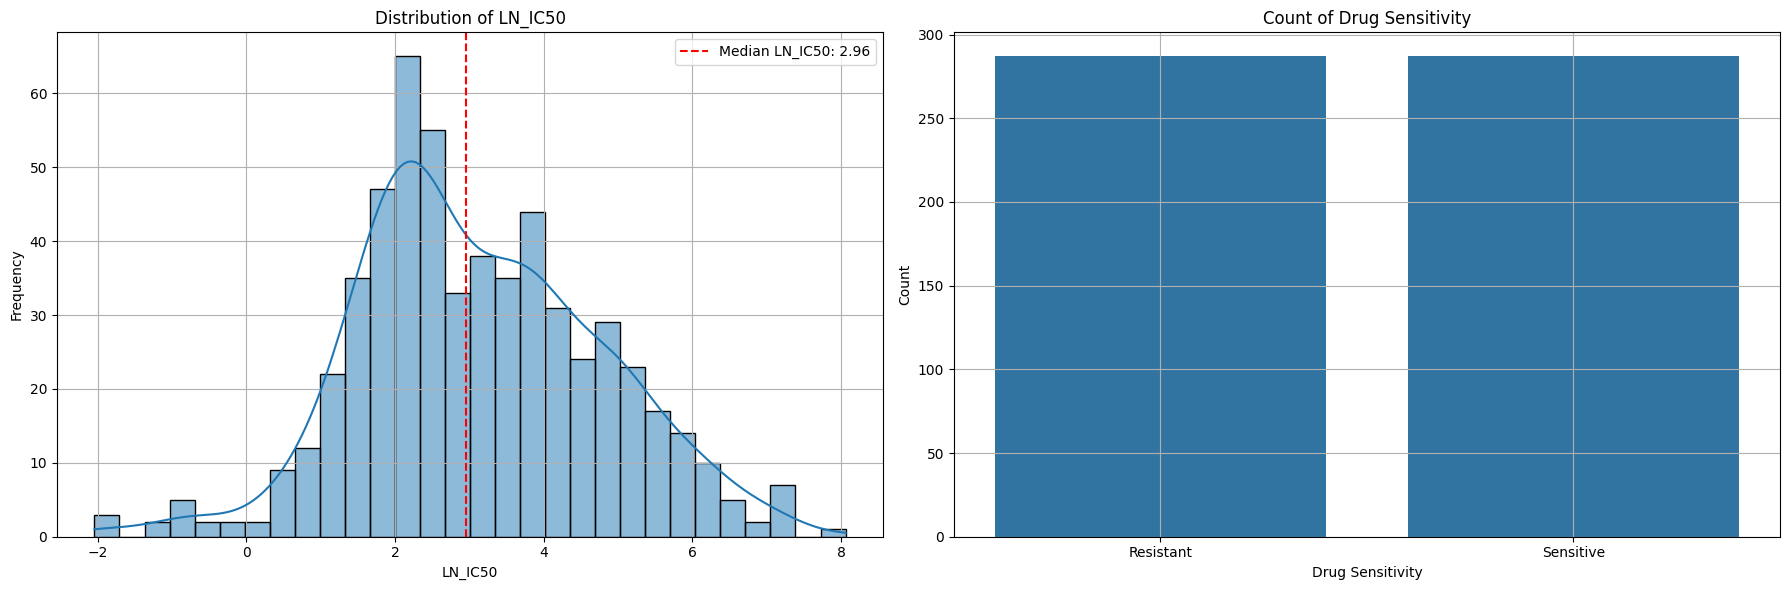

In [12]:
# Drug sensitivity distribution and binary split countplot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histplot for LN_IC50
sns.histplot(merged_df['LN_IC50'], bins=30, kde=True, ax=axes[0])
axes[0].set_xlabel('LN_IC50')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of LN_IC50')
axes[0].axvline(threshold, color='red', linestyle='--', linewidth=1.5, label=f'Median LN_IC50: {threshold:.2f}')
axes[0].grid(True)
axes[0].legend()

# Countplot for Drug_Sensitivity
sns.countplot(data=merged_df, x='Drug_Sensitivity', ax=axes[1])
axes[1].set_xlabel('Drug Sensitivity')
axes[1].set_ylabel('Count')
axes[1].set_title('Count of Drug Sensitivity')
axes[1].grid(True)

plt.tight_layout()
plt.savefig("output/data_exploration/drug_sensitivity_distribution.pdf")
plt.show()

In [13]:
# Calculate the correlation matrix
corr_matrix = expr.iloc[:, 1:].corr().abs()

# Flatten the correlation matrix
corr_flat = corr_matrix.unstack()

# Sort correlations in descending order
corr_flat_sorted = corr_flat.sort_values(ascending=False)

# Remove duplicate pairs and self-correlations
corr_flat_sorted = corr_flat_sorted[corr_flat_sorted.index.get_level_values(0) != corr_flat_sorted.index.get_level_values(1)]

# Select top 100 most correlated pairs
top_100_corr = corr_flat_sorted.head(100)


In [14]:
# Get unique genes from the top 100 correlations
top_genes = set(top_100_corr.index.get_level_values(0)) | set(top_100_corr.index.get_level_values(1))

# Subset the expression dataframe to these top genes
expr_top_100 = expr.iloc[:, 1:][list(top_genes)]

# Recalculate the correlation matrix for these top genes
top_100_corr_matrix = expr_top_100.corr()

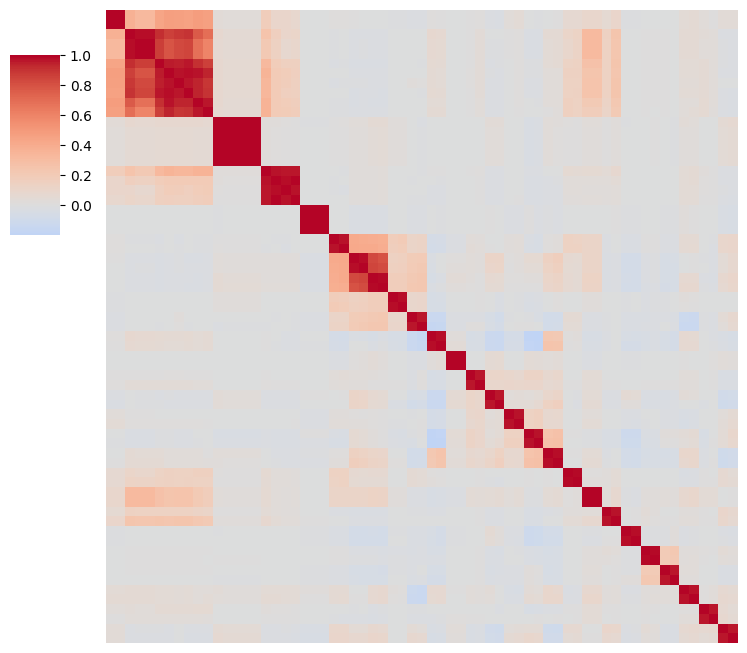

In [15]:
# Create the clustered heatmap
clustmap = sns.clustermap(top_100_corr_matrix, 
                          cmap='coolwarm', 
                          center=0, 
                          figsize=(10, 10),
                          cbar_pos=(0.08, 0.6, 0.05, 0.18))  

# Remove dendrograms
clustmap.ax_row_dendrogram.set_visible(False)
clustmap.ax_col_dendrogram.set_visible(False)

# Remove axes labels and ticks
clustmap.ax_heatmap.set_xticks([])
clustmap.ax_heatmap.set_yticks([])
clustmap.ax_heatmap.set_xlabel('')
clustmap.ax_heatmap.set_ylabel('')

# Save the figure
plt.savefig("output/data_exploration/gene_expr_corr_clustered_heatmap.pdf", bbox_inches='tight')
plt.show()

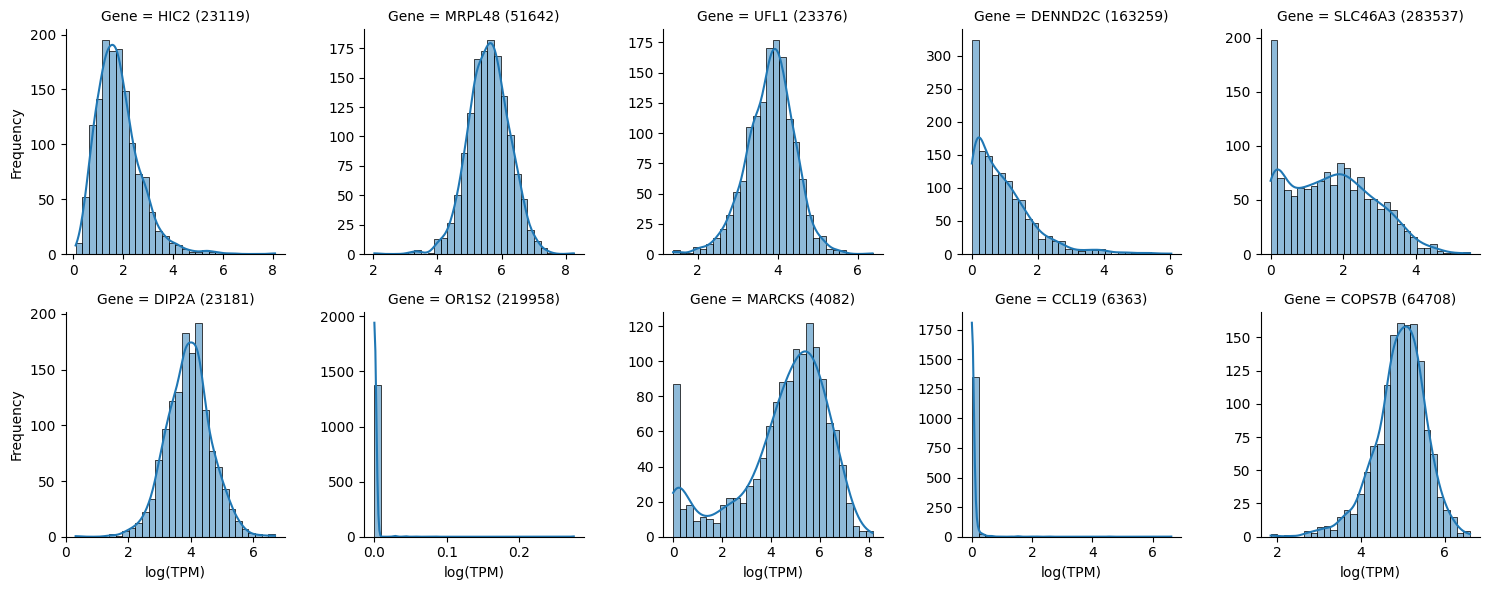

In [16]:
# Check the distribution of gene expression values (randomly selected for computational efficiency)

# Randomly select 5 genes
random_genes = expr.iloc[:, 1:].sample(n=10, axis=1, random_state=42)

# Facet the histplot for each gene
g = sns.FacetGrid(random_genes.melt(var_name='Gene', value_name='Expression'), col='Gene', col_wrap=5, sharex=False, sharey=False)
g.map(sns.histplot, 'Expression', bins=30, kde=True)
g.set_xlabels('log(TPM)')
g.set_ylabels('Frequency')
plt.savefig("output/data_exploration/gene_expr-histogram.pdf")
plt.show()


### Evaluation of gene expression data

As expected from gene expression data, there are correlations even within randomly sampled genes. Also, the distribution of gene expression values show signs of skewness.

Conclusions:

- Models which can deal with covariance of features will probably be better suited for this dataset
- Standardization of the gene expression values is warranted. Will need to check the effect of such transformation. This only applies to gene expression values which are continuous and are not binned (see below).

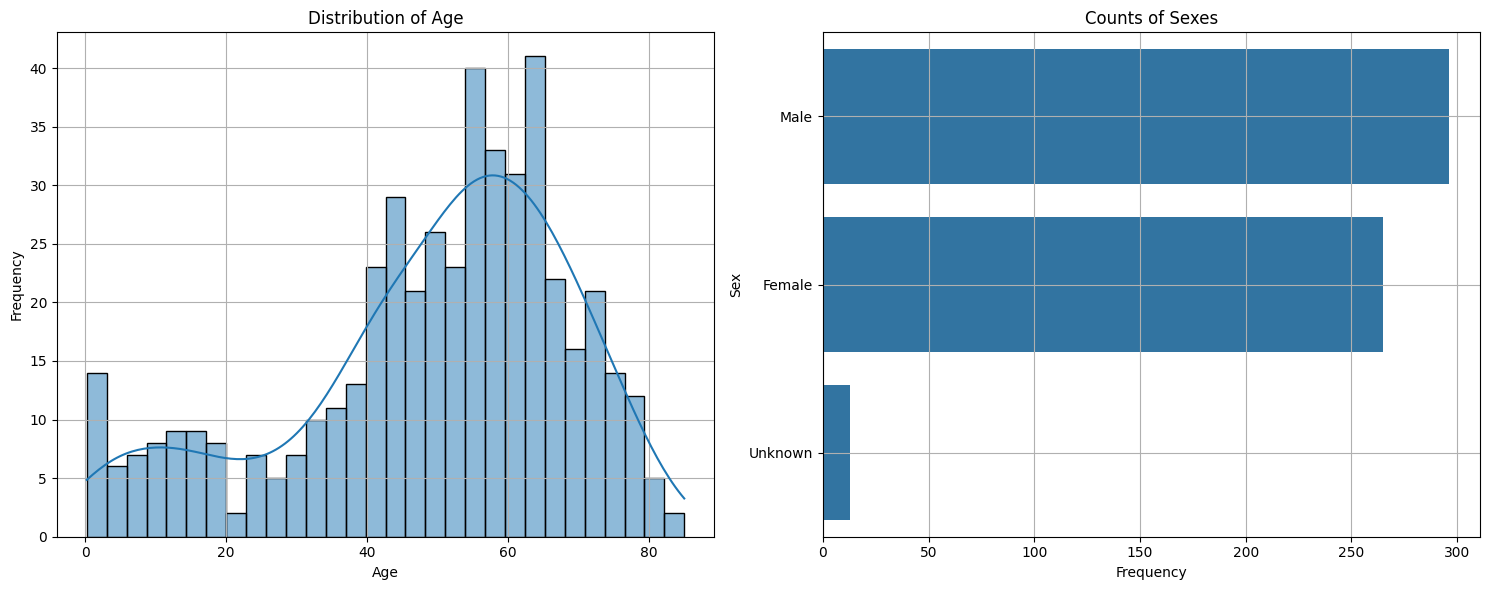

In [17]:
# Check metadata features
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(merged_df['age'], bins=30, kde=True, ax=axes[0])
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Age')
axes[0].grid(True)

sns.countplot(merged_df['sex'], ax=axes[1])
axes[1].set_ylabel('Sex')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Counts of Sexes')
axes[1].grid(True)

plt.tight_layout()
plt.savefig("output/data_exploration/age-sexes.pdf")
plt.show()

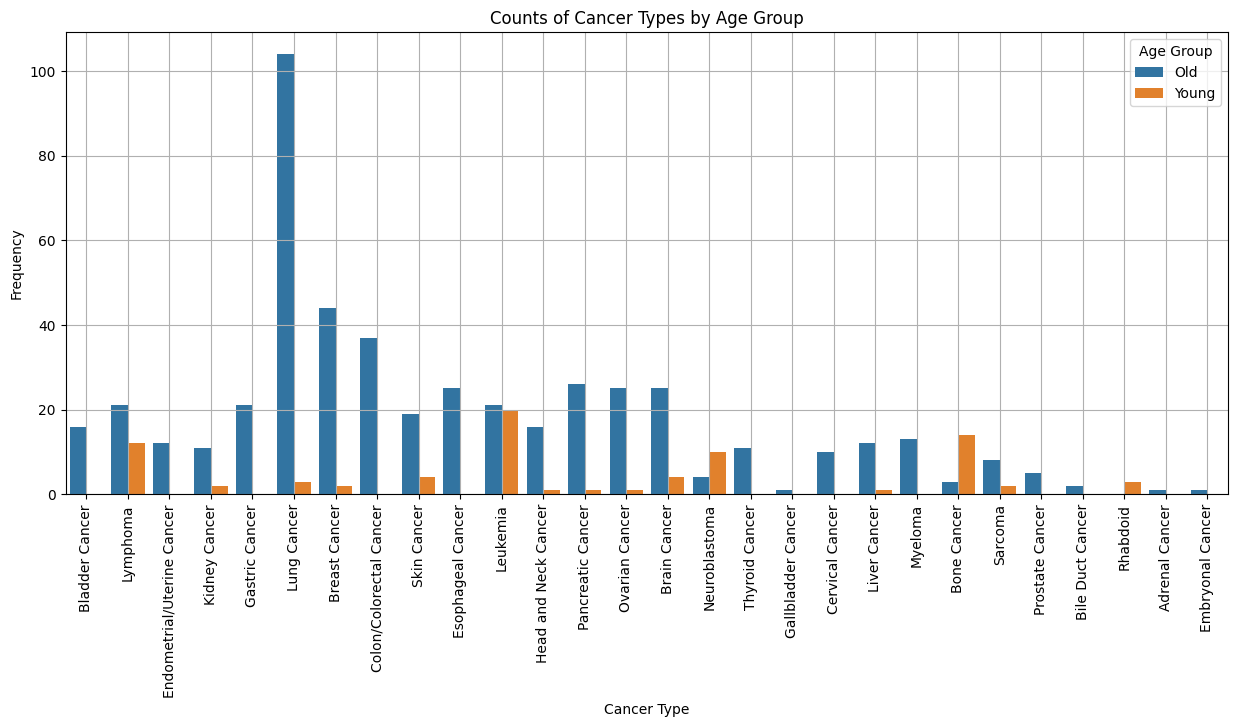

In [18]:
# Check the cancer types in young and old patients

# Define the age groups
merged_df['Age_Group'] = ['Young' if age < 30 else 'Old' for age in merged_df['age']]
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

# Plot the counts of cancer types by age group
sns.countplot(data=merged_df, x='primary_disease', hue='Age_Group', ax=axes)
axes.set_ylabel('Frequency')
axes.set_xlabel('Cancer Type')
axes.set_title('Counts of Cancer Types by Age Group')
axes.grid(True)
axes.legend(title='Age Group')
plt.xticks(rotation=90)
plt.savefig("output/data_exploration/disease_type-by-age.pdf")
plt.show()

### Evaluation of metadata

- Age seems to be biased towards middle-to-elderly group. This is to be expected as cancerous cell alterations usually appear later on during life-time due to accumulating mutations. 
- Some sexes are unknown, will drop these for the analysis downstream.
- Some cancer types are more prevalent in different age groups. There are high imbalances in age groups if classified in a binary way. 

In [19]:
# Investigate the Euclidean distance of each observation in the gene expression space

# Extract observation names and numerical values
observations = merged_df.iloc[:, 0]
numerical_data = merged_df.iloc[:, 1:(expr.shape)[1]]

# Calculate pairwise Euclidean distances
distances = pdist(numerical_data, metric='euclidean')

# Convert to a square distance matrix
distance_matrix = squareform(distances)

# Create a DataFrame for the distance matrix
distance_df = pd.DataFrame(distance_matrix, index=observations, columns=observations)

/projects/ferenc.kagan/ML/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/projects/ferenc.kagan/ML/.venv/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/projects/ferenc.kagan/ML/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/projects/ferenc.kagan/ML/.venv/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


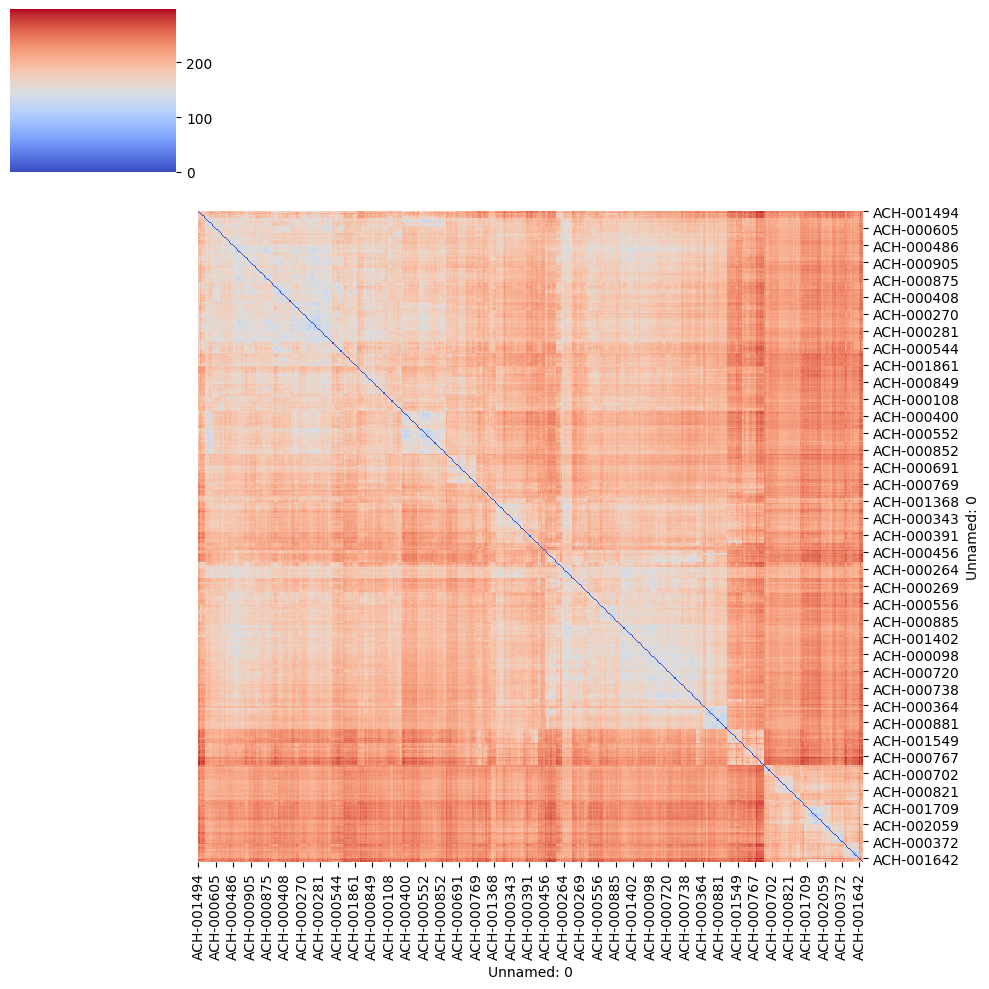

In [20]:
# Plot the clustermap with annotations
clustmap = sns.clustermap(
    distance_df,
    cmap='coolwarm',
    figsize=(10, 10)
)

# Remove row and column dendrograms
clustmap.ax_row_dendrogram.set_visible(False)
clustmap.ax_col_dendrogram.set_visible(False)

# Adjust layout to make room for the legend
plt.tight_layout()

# Save the heatmap with annotations
clustmap.figure.savefig("output/data_exploration/sample_distances.pdf", bbox_inches='tight')
plt.show()


### Variance thresholding to filter genes of low variance
Some genes might not be important and we would like to reduce model complexity.

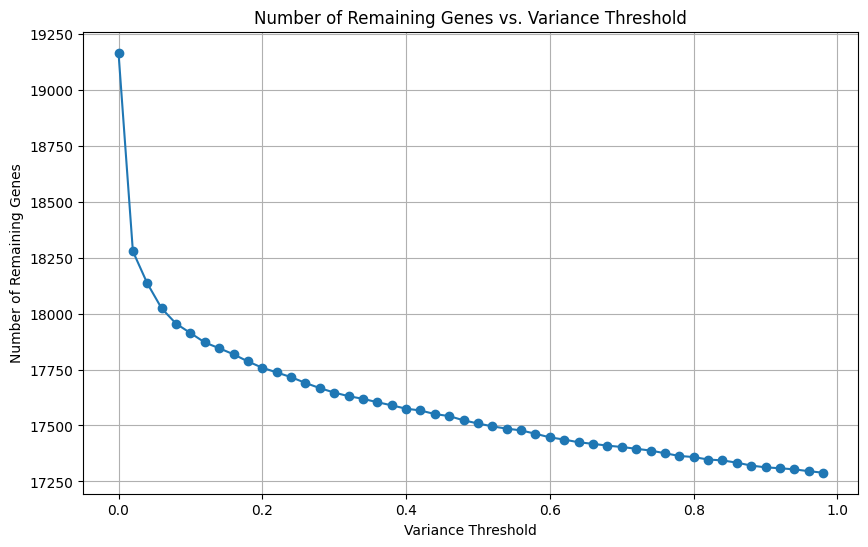

In [21]:
# Define a threshold for variance (you can adjust this threshold depending on your data)
# Initialize lists to store results
thresholds = []
remaining_genes = []

# Transform the data from ln scale to normal scale
norm_scale_expr = np.exp(merged_df.iloc[:, 1:(expr.shape)[1]])

# Iterate over the range of thresholds
for threshold in np.arange(0.00, 1.0, 0.02):
    # Initialize VarianceThreshold with the current threshold
    var_thresh = VarianceThreshold(threshold=threshold)
    
    # Fit the variance threshold to the imputed data
    boxcox_imputed_filtered = var_thresh.fit_transform(norm_scale_expr)
    
    # Store the threshold and the number of remaining features (genes)
    thresholds.append(threshold)
    remaining_genes.append(boxcox_imputed_filtered.shape[1])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, remaining_genes, marker='o')
plt.xlabel('Variance Threshold')
plt.ylabel('Number of Remaining Genes')
plt.title('Number of Remaining Genes vs. Variance Threshold')
plt.grid(True)
plt.savefig('output/data_exploration/variance-thresholding.pdf')
plt.show()

In [22]:
# Remove constant features
# Define the threshold for variance
threshold = 0.02

# Initialize VarianceThreshold with the threshold
var_thresh = VarianceThreshold(threshold=threshold)

# Fit the variance threshold to the imputed data
var_thresh = var_thresh.fit_transform(norm_scale_expr)

### Feature distribution transormations
Many genes show skewed distributions, which will need to be adjusted.

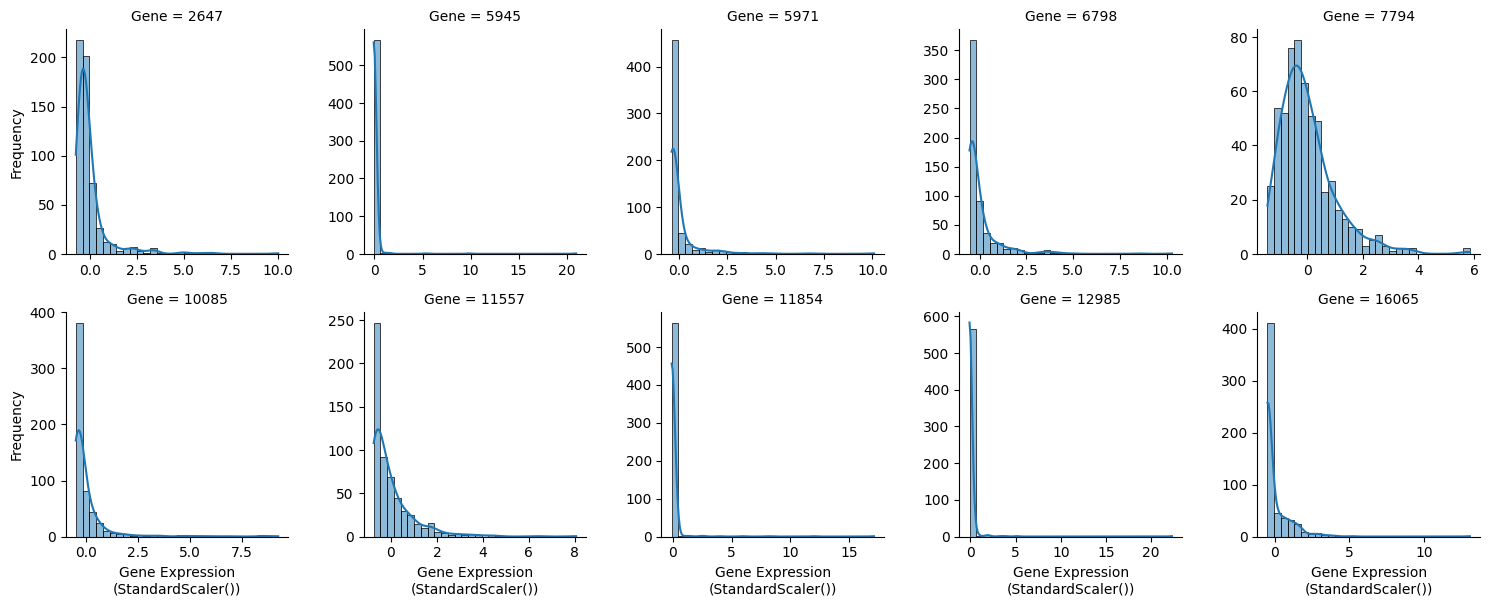

In [23]:
# Check the distribution of gene expression values (randomly selected for computational efficiency)

# Extract the transformed gene expression values
scaler = StandardScaler()
boxcox_transformed = scaler.fit_transform(var_thresh)

# Randomly select 5 genes
random_genes_boxcox = pd.DataFrame(boxcox_transformed).sample(n=10, axis=1, random_state=42)

# Facet the histplot for each gene
g = sns.FacetGrid(random_genes_boxcox.melt(var_name='Gene', value_name='Expression'), col='Gene', col_wrap=5, sharex=False, sharey=False)
g.map(sns.histplot, 'Expression', bins=30, kde=True)
g.set_xlabels('Gene Expression\n(StandardScaler())')
g.set_ylabels('Frequency')
g.figure.savefig("output/data_exploration/gene_expr-box_cox_transformed.pdf")
plt.show()

### Outlier detection and removal

In [24]:
# Initialize the IsolationForest model
iso_forest = IsolationForest(random_state=42)

# Fit the model to the boxcox_transformed data
iso_forest.fit(boxcox_transformed)

# Predict the outliers
outliers = iso_forest.predict(boxcox_transformed)

# Convert the outliers array to a boolean mask
outlier_mask = outliers == -1

# Print the number of outliers detected
print(f'Number of outliers detected: {np.sum(outlier_mask)}')

# Print indices of the outliers
outlier_indices = np.where(outlier_mask)[0]
print(f'Indices of outliers: {outlier_indices}')

Number of outliers detected: 0
Indices of outliers: []


In [25]:
# Annotate outliers in the data by replacing flagged values with NaN
boxcox_transformed_with_nan = boxcox_transformed.copy()
boxcox_transformed_with_nan[outlier_mask, :] = np.nan

# Initialize the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply k-NN imputation to the data with NaN values
boxcox_imputed = knn_imputer.fit_transform(boxcox_transformed_with_nan)

# Print confirmation
print("k-NN imputation complete. Imputed data saved.")

k-NN imputation complete. Imputed data saved.


### Dimensionality reduction (DR) and visualization

Will experiment with a standard PCA and a more complicated DR algorithm, t-SNE. As PCA requires features having a Gaussian distribution I will first transform the `ln` scale of the data to its original scale and then I will use `Box-Cox` to approximate the normal distribution.

In [26]:
# Setting up pipelines for DR
pca_pipeline = Pipeline([
    ('pca', PCA(n_components=2)) # PCA is used to reduce the dimensionality of the data
])

tsne_pipeline = Pipeline([
    ('tsne', TSNE(n_components=2)) # tsne is used to reduce the dimensionality of the data
])

mds_pipeline = Pipeline([
    ('mds', MDS(n_components=2, random_state=42)) # MDS is used to reduce the dimensionality of the data
])

# Fit the pipelines to the data
pca_transformed = pca_pipeline.fit_transform(boxcox_imputed)
tsne_transformed = tsne_pipeline.fit_transform(boxcox_imputed)
mds_transformed = mds_pipeline.fit_transform(boxcox_imputed)

# Create a DataFrame for the transformed data
pca_df = pd.DataFrame(pca_transformed, columns=['PCA1', 'PCA2'])
tsne_df = pd.DataFrame(tsne_transformed, columns=['tsne1', 'tsne2'])
mds_df = pd.DataFrame(mds_transformed, columns=['MDS1', 'MDS2'])

# Add the metadata for visualization
pca_df['Age'] = merged_df['age']
pca_df['Sex'] = merged_df['sex']
pca_df['Primary_Disease'] = merged_df['primary_disease']

tsne_df['Age'] = merged_df['age']
tsne_df['Sex'] = merged_df['sex']
tsne_df['Primary_Disease'] = merged_df['primary_disease']

mds_df['Age'] = merged_df['age']
mds_df['Sex'] = merged_df['sex']
mds_df['Primary_Disease'] = merged_df['primary_disease']

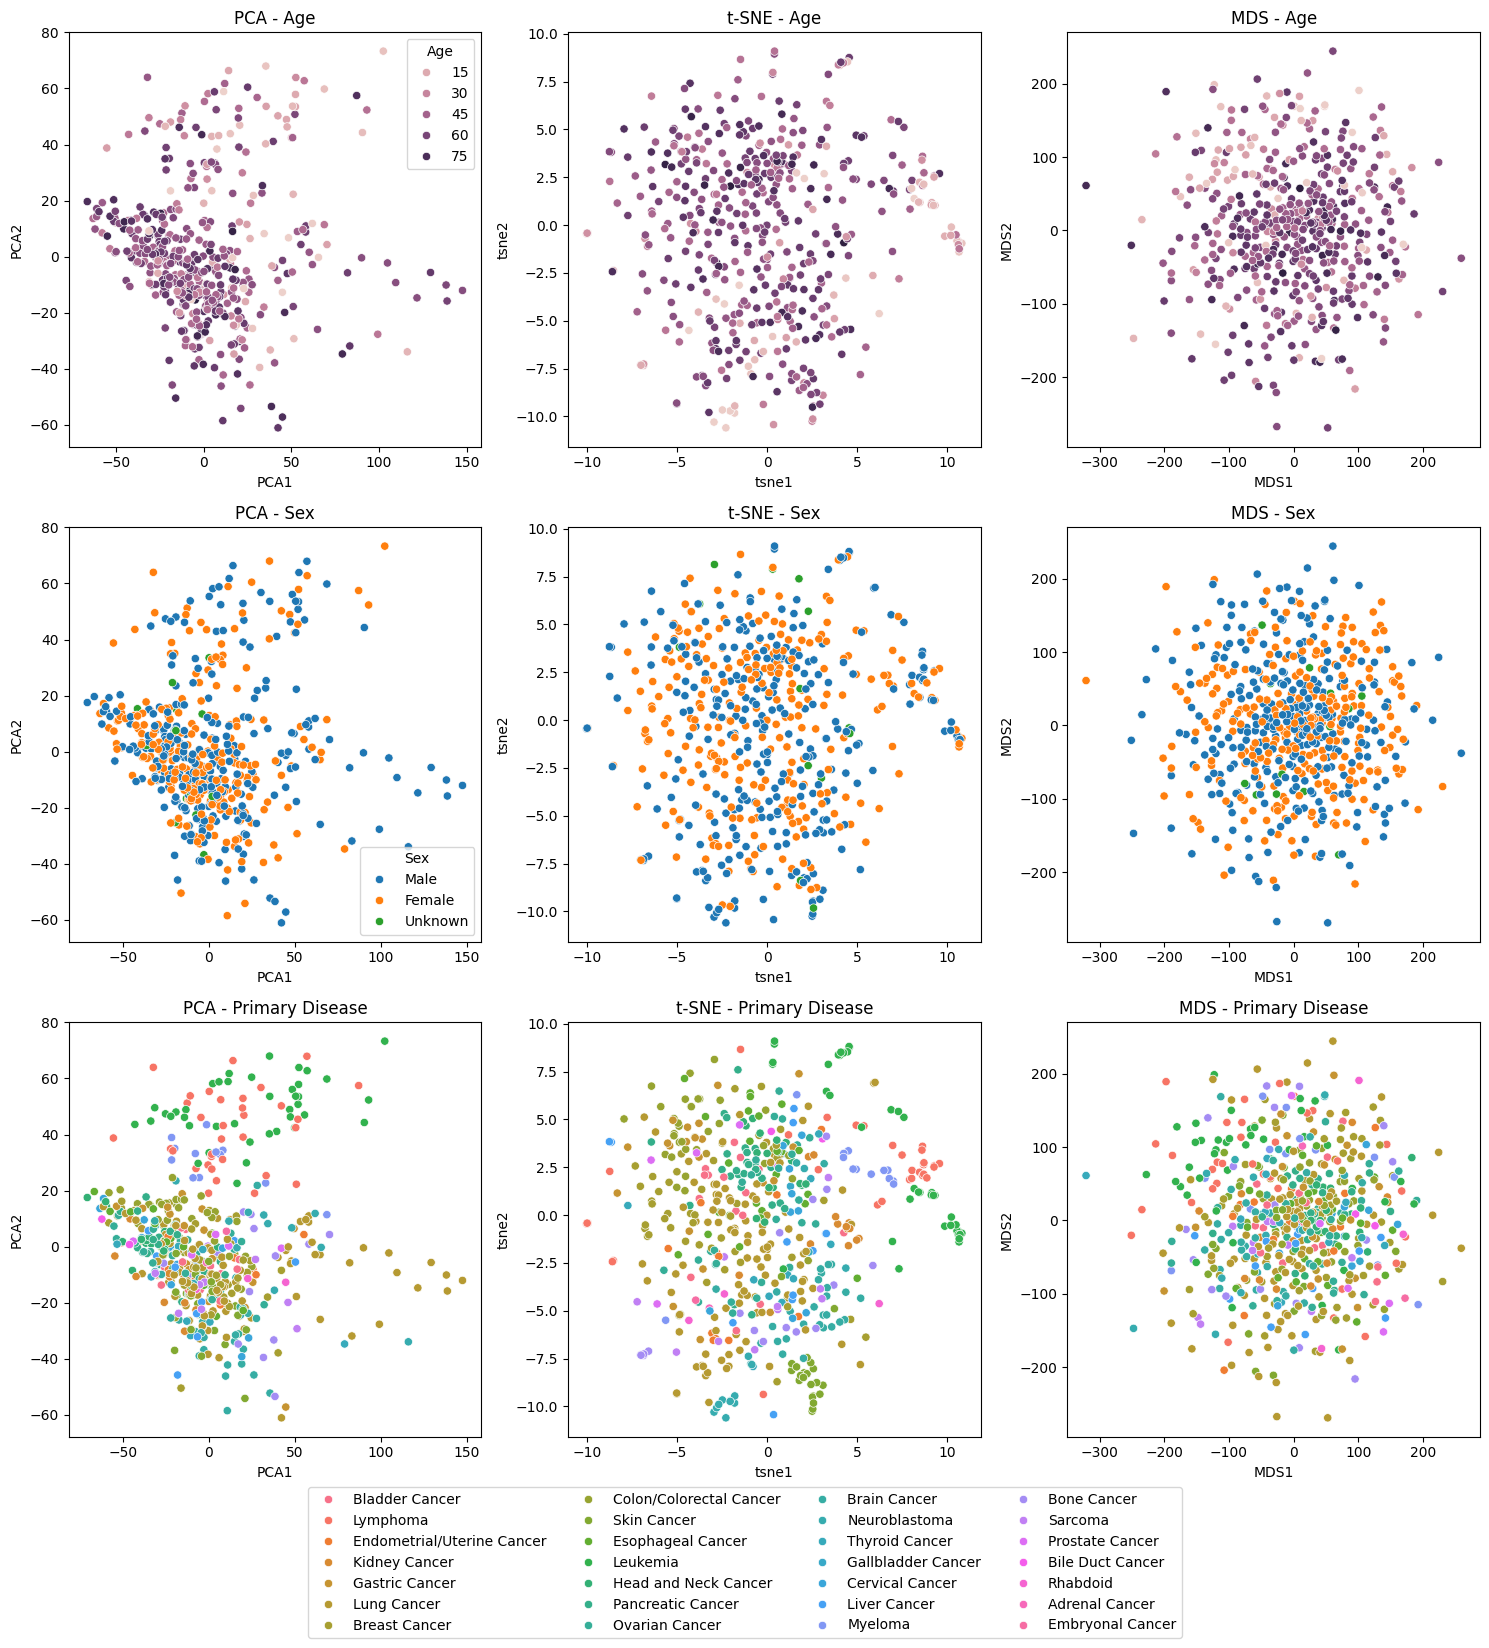

In [27]:
# Plot the results
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# PCA plots
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Age', ax=axes[0, 0], legend=True)
axes[0, 0].set_title('PCA - Age')

sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Sex', ax=axes[1, 0], legend=True)
axes[1, 0].set_title('PCA - Sex')

pca_plot=sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Primary_Disease', ax=axes[2, 0], legend='full')
axes[2, 0].set_title('PCA - Primary Disease')
axes[2, 0].get_legend().remove()
handles, labels = pca_plot.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))
fig.tight_layout(rect=[0, 0.1, 1, 0.95])

# t-SNE plots without individual legends
sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='Age', ax=axes[0, 1], legend=False)
axes[0, 1].set_title('t-SNE - Age')

sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='Sex', ax=axes[1, 1], legend=False)
axes[1, 1].set_title('t-SNE - Sex')

sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='Primary_Disease', ax=axes[2, 1], legend=False)
axes[2, 1].set_title('t-SNE - Primary Disease')

# MDS plots without individual legends
sns.scatterplot(data=mds_df, x='MDS1', y='MDS2', hue='Age', ax=axes[0, 2], legend=False)
axes[0, 2].set_title('MDS - Age')

sns.scatterplot(data=mds_df, x='MDS1', y='MDS2', hue='Sex', ax=axes[1, 2], legend=False)
axes[1, 2].set_title('MDS - Sex')

sns.scatterplot(data=mds_df, x='MDS1', y='MDS2', hue='Primary_Disease', ax=axes[2, 2], legend=False)
axes[2, 2].set_title('MDS - Primary Disease')

plt.tight_layout()
plt.savefig("output/data_exploration/dr.pdf")
plt.show()

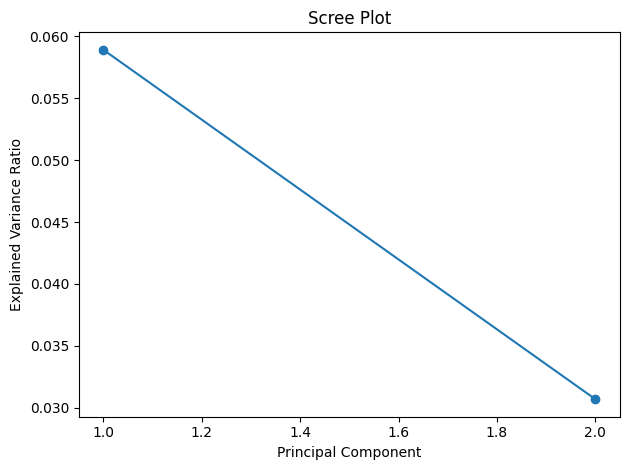

Explained variance ratio: 8.96%


In [28]:
# Check the explained variance ratio for PCA
# Define number of components
components = range(1, 3)

# Scree plot for PCA
plt.plot(components, pca_pipeline.named_steps['pca'].explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.tight_layout()

plt.show()

# Print out explained variance % from the two components
print(f'Explained variance ratio: {pca_pipeline.named_steps["pca"].explained_variance_ratio_.sum()*100:.2f}%')

### Correlations with the target variable

Will check the gene expression Pearons's correlations with the target variable (`LN_IC50`). 

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Compute Global Correlations
global_correlation = pd.DataFrame(boxcox_imputed).corrwith(merged_df['LN_IC50']).sort_values(ascending=False)
global_correlation.name = "Global"

# Create output directory if it doesn't exist
os.makedirs('output/data_exploration/correlation_plots', exist_ok=True)

# Plotting Global Correlations
plt.figure(figsize=(12, 6))
sns.barplot(x=global_correlation.index, y=global_correlation.values)

plt.title("Global Correlation of Gene Expression with LN_IC50")
plt.ylabel("Correlation Coefficient")
plt.xlabel("") 
plt.xticks([]) 

# Adjust layout and save the global correlation plot
plt.tight_layout()
plt.savefig('output/data_exploration/correlation_plots/Global_correlation.pdf', bbox_inches='tight')
plt.close()

print("Global correlation plot has been saved as 'Global_correlation.pdf' in the 'output/data_exploration/correlation_plots' directory.")

# Compute Segment-wise Correlations
segment_correlations = {}

for disease in merged_df['primary_disease'].unique():
    filtered_df = merged_df[merged_df['primary_disease'] == disease]
    filtered_X = pd.DataFrame(boxcox_imputed).loc[filtered_df.index]
    filtered_y = filtered_df['LN_IC50']
    correlations = pd.DataFrame(filtered_X).corrwith(filtered_y).sort_values(ascending=False)
    segment_correlations[disease] = correlations

# Convert to a single DataFrame
correlation_df = pd.DataFrame(segment_correlations)
correlation_df['Global'] = global_correlation  # Add the global correlations

# Create output directory if it doesn't exist
os.makedirs('output/data_exploration/correlation_plots', exist_ok=True)

# Plotting
plt.figure(figsize=(12, 6))

# Plotting Segment-wise Correlations
for segment in correlation_df.columns:
    # Check if there's data for this segment
    if correlation_df[segment].notna().sum() > 0:
        # Sort correlations in descending order
        sorted_correlations = correlation_df[segment].sort_values(ascending=False)
        
        # Plot
        plt.figure(figsize=(12, 6))
        sns.pointplot(x=sorted_correlations.index, y=sorted_correlations.values, order=sorted_correlations.index)
        
        plt.title(f"Correlation of Gene Expression with LN_IC50 for {segment}")
        plt.ylabel("Correlation Coefficient")
        plt.xlabel("")  
        plt.xticks([])
        plt.grid() 
        
        # Adjust layout and save
        plt.tight_layout()
        # Create a valid filename
        filename = f"{segment.replace('/', '_').replace(' ', '_')}_correlation.pdf"
        plt.savefig(f'output/data_exploration/correlation_plots/{filename}', bbox_inches='tight')
        plt.close()
    else:
        print(f"No data available for segment: {segment}")

print("Correlation plots have been saved in the 'output/data_exploration/correlation_plots' directory.")

Global correlation plot has been saved as 'Global_correlation.pdf' in the 'output/data_exploration/correlation_plots' directory.


/projects/ferenc.kagan/ML/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/projects/ferenc.kagan/ML/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


/projects/ferenc.kagan/ML/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/projects/ferenc.kagan/ML/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/projects/ferenc.kagan/ML/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


No data available for segment: Gallbladder Cancer


No data available for segment: Adrenal Cancer
No data available for segment: Embryonal Cancer


Correlation plots have been saved in the 'output/data_exploration/correlation_plots' directory.


<Figure size 1200x600 with 0 Axes>

In [30]:
import numpy as np
from numpy import array, random, arange

# Experimenting with xi correlation for non-linear association detection
# Source: https://doi.org/10.1080/01621459.2020.1758115
def xicor(X, Y, ties=True):
    random.seed(42)
    n = len(X)
    order = array([i[0] for i in sorted(enumerate(X), key=lambda x: x[1])])
    if ties:
        l = array([sum(y >= Y[order]) for y in Y[order]])
        r = l.copy()
        for j in range(n):
            if sum([r[j] == r[i] for i in range(n)]) > 1:
                tie_index = array([r[j] == r[i] for i in range(n)])
                r[tie_index] = random.choice(r[tie_index] - arange(0, sum([r[j] == r[i] for i in range(n)])), sum(tie_index), replace=False)
        return 1 - n*sum( abs(r[1:] - r[:n-1]) ) / (2*sum(l*(n - l)))
    else:
        r = array([sum(y >= Y[order]) for y in Y[order]])
        return 1 - 3 * sum( abs(r[1:] - r[:n-1]) ) / (n**2 - 1)


# Compute Global Xi Correlations
global_correlation = pd.Series(
    [xicor(boxcox_imputed[:, i], merged_df['LN_IC50'].values) for i in range(boxcox_imputed.shape[1])],
    index=pd.DataFrame(boxcox_imputed).columns
).sort_values(ascending=False)
global_correlation.name = "Global"

# Create output directory if it doesn't exist
os.makedirs('output/data_exploration/xi_correlation_plots', exist_ok=True)

# Plotting Global Xi Correlation
plt.figure(figsize=(12, 6))
sns.barplot(x=global_correlation.index, y=global_correlation.values)

plt.title("Global Xi Correlation of Gene Expression with LN_IC50")
plt.ylabel("Xi Correlation Coefficient")
plt.xlabel("")  
plt.xticks([])

# Save the global Xi correlation plot
plt.tight_layout()
plt.savefig('output/data_exploration/xi_correlation_plots/Global_Xi_Correlation.pdf', bbox_inches='tight')
plt.close()

print("Global Xi correlation plot has been saved as 'Global_Xi_Correlation.pdf' in the 'output/data_exploration/xi_correlation_plots' directory.")

# Compute Segment-wise Xi Correlations
segment_correlations = {}

for disease in merged_df['primary_disease'].unique():
    filtered_df = merged_df[merged_df['primary_disease'] == disease]
    filtered_X = pd.DataFrame(boxcox_imputed).loc[filtered_df.index]
    filtered_y = filtered_df['LN_IC50'].values
    correlations = pd.Series(
        [xicor(filtered_X.iloc[:, i].values, filtered_y) for i in range(filtered_X.shape[1])],
        index=filtered_X.columns
    ).sort_values(ascending=False)
    segment_correlations[disease] = correlations

# Plotting Segment-wise Correlations
for segment in correlation_df.columns:
    # Check if there's data for this segment
    if correlation_df[segment].notna().sum() > 0:
        # Sort correlations in descending order
        sorted_correlations = correlation_df[segment].sort_values(ascending=False)
        
        # Plot
        plt.figure(figsize=(12, 6))
        sns.pointplot(x=sorted_correlations.index, y=sorted_correlations.values, order=sorted_correlations.index)
        
        plt.title(f"Xi correlation of Gene Expression with LN_IC50 for {segment}")
        plt.ylabel("Xi correlation Coefficient")
        plt.xlabel("")  
        plt.xticks([])
        plt.grid() 
        
        # Adjust layout and save
        plt.tight_layout()
        # Create a valid filename
        filename = f"{segment.replace('/', '_').replace(' ', '_')}_correlation.pdf"
        plt.savefig(f'output/data_exploration/xi_correlation_plots/{filename}', bbox_inches='tight')
        plt.close()
    else:
        print(f"No data available for segment: {segment}")

print("Correlation plots have been saved in the 'output/data_exploration/xi_correlation_plots' directory.")

Global Xi correlation plot has been saved as 'Global_Xi_Correlation.pdf' in the 'output/data_exploration/xi_correlation_plots' directory.


/tmp/ipykernel_2585574/3506473626.py:17: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - n*sum( abs(r[1:] - r[:n-1]) ) / (2*sum(l*(n - l)))


No data available for segment: Gallbladder Cancer


No data available for segment: Adrenal Cancer
No data available for segment: Embryonal Cancer


Correlation plots have been saved in the 'output/data_exploration/xi_correlation_plots' directory.


### Evaluation of EDA

- No apparent grouping present in the dataset according to sex, age, or primary disease
- Difficult to disentangle if the PCA (which works best with linear associations across features), or t-SNE, or MDS worked best.
- Standard PCA first two principal components capture only a small amount of the variation (see `Scree Plot` above).
- The `StandardScaler()` transformation seems to work for some genes and fail for others. Performance was evaluated based on visual inspection.
    - Multiple genes are 0 inflated, i.e. they have no expression value in some cancer types and have expressions in others. In these cases it is difficult to bring them close to a normal distribution.
- Gene expressions vary in their correlation with the drug sensitivity. Some have high, some have low correlation coefficients. Some are negatively correlated, while others are positively correlated. This is all based on Pearson's correlation coefficient, which assumes a linear relationship. 

### Strategies for building ML models

- All TPM values are meant to be interpreted after pre-processing. I will use the pre-processing steps outlined above (`Box-Cox transformation`, outlier detection with `Isolation forrest`, imputing of outlier values with `k-NN`, `Variance thresholding`, correlation based removal of genes).
- The approaches I want to implement are:
    - Will try the TPM values from gene expression data
    - Will try the TPM values from gene expression data being binned to reduce data complexity
    - Will try the TPM values from gene expression data enchanced by other metadata (ex. primary_disease, age, sex as these could be really important)
    - Will try a dimensionality reduction technique for the expression dataset
    - Will try a dimensionality reduction technique for the expression dataset enchanced by other metadata (ex. priamry_disease, age, sex as these could be really important)

- Will also experiment with `VotingRegressor` or `VotingClassifier`